In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.stats import norm
import time

In [2]:

def european_call_bs_explicit(k,r,sigma,T,dt,ds,s_max):
    

    t_count=int(T/dt)+1
    s_count=int(s_max/ds)+1


    t_lin=np.linspace(0,T,t_count)

    x_lin=np.linspace(0,s_max,s_count)
    
    j_index=np.arange(0,len(x_lin)+1)

    
    payoff=lambda s: np.maximum(s-k,0)
    payoff=np.vectorize(payoff)

    value=np.zeros((s_count,t_count))
    value[:,t_count-1]=payoff(x_lin)
    value[0,:]=0
    value[s_count-1,:]=s_max-k*np.exp(-r*(T-t_lin))

    a=0.5*dt*(sigma**2*j_index[1:s_count-1]**2-r*j_index[1:s_count-1])
    
    b=1-dt*(sigma**2*j_index[1:s_count-1]**2+r)

    c= 0.5*dt*(sigma**2*j_index[1:s_count-1]**2+r*j_index[1:s_count-1])


    for i in range(t_count-2,-1,-1):
        value[1:s_count-1,i]= a*value[0:s_count-2,i+1]+ b*value[1:s_count-1,i+1] + c*value[2:s_count,i+1]

    return value[:,0]




In [3]:

def european_call_bs_cn(k,r,sigma,T,dt,ds,s_max):

    

    t_count=int(T/dt)+1
    s_count=int(s_max/ds)+1


    t_lin=np.linspace(0,T,t_count)

    x_lin=np.linspace(0,s_max,s_count)
    j_index=np.arange(0,len(x_lin)+1)


    payoff=lambda s: np.maximum(s-k,0)
    payoff=np.vectorize(payoff)

    value=np.zeros((s_count,t_count))

    value[:,t_count-1]=payoff(x_lin)
    value[0,:]=0
    value[s_count-1,:]=s_max-k*np.exp(-r*(T-t_lin))

    a=0.25*dt*(sigma**2*j_index[1:s_count-1]**2-r*j_index[1:s_count-1])


    b=-0.5*dt*(sigma**2*j_index[1:s_count-1]**2+r)

    c= 0.25*dt*(sigma**2*j_index[1:s_count-1]**2+r*j_index[1:s_count-1])


    B=np.zeros((s_count-2,s_count-2))
    C=np.zeros((s_count-2,s_count-2))


    for i in range(s_count-2):
        if i==0:
            B[i,i]=1-b[i]
            B[i,i+1]=-c[i]

            C[i,i]=1+b[i]
            C[i,i+1]=c[i]
        if i==s_count-3:
            B[i,i]=1-b[i]
            B[i,i-1]=-a[i]

            C[i,i]=1+b[i]
            C[i,i-1]=a[i]
        else:
            B[i,i]=1-b[i]
            B[i,i+1]=-c[i]
            B[i,i-1]=-a[i]

            C[i,i]=1+b[i]
            C[i,i+1]=c[i]
            C[i,i-1]=a[i]



    aux=np.zeros(s_count-2)
    for i in range(t_count-2,-1,-1):
        aux[0]=a[0]*(value[0,i]+value[0,i+1])
        value[1:s_count-1,i]= np.linalg.solve(B,C.dot(value[1:s_count-1,i+1])+aux)
    return value[:,0]

In [4]:

def american_call_bs_cn(k,r,sigma,T,dt,ds,s_max):

    

    t_count=int(T/dt)+1
    s_count=int(s_max/ds)+1


    t_lin=np.linspace(0,T,t_count)

    x_lin=np.linspace(0,s_max,s_count)
    j_index=np.arange(0,len(x_lin)+1)


    payoff=lambda s: np.maximum(s-k,0)
    payoff=np.vectorize(payoff)

    value=np.zeros((s_count,t_count))

    value[:,t_count-1]=payoff(x_lin)
    value[0,:]=0
    value[s_count-1,:]=s_max-k*np.exp(-r*(T-t_lin))

    a=0.25*dt*(sigma**2*j_index[1:s_count-1]**2-r*j_index[1:s_count-1])


    b=-0.5*dt*(sigma**2*j_index[1:s_count-1]**2+r)

    c= 0.25*dt*(sigma**2*j_index[1:s_count-1]**2+r*j_index[1:s_count-1])


    B=np.zeros((s_count-2,s_count-2))
    C=np.zeros((s_count-2,s_count-2))


    for i in range(s_count-2):
        if i==0:
            B[i,i]=1-b[i]
            B[i,i+1]=-c[i]

            C[i,i]=1+b[i]
            C[i,i+1]=c[i]
        if i==s_count-3:
            B[i,i]=1-b[i]
            B[i,i-1]=-a[i]

            C[i,i]=1+b[i]
            C[i,i-1]=a[i]
        else:
            B[i,i]=1-b[i]
            B[i,i+1]=-c[i]
            B[i,i-1]=-a[i]

            C[i,i]=1+b[i]
            C[i,i+1]=c[i]
            C[i,i-1]=a[i]



    aux=np.zeros(s_count-2)
    for i in range(t_count-2,-1,-1):
        aux[0]=a[0]*(value[0,i]+value[0,i+1])
        value[1:s_count-1,i]= np.linalg.solve(B,C.dot(value[1:s_count-1,i+1])+aux)
        value[1:s_count-1,i]=np.maximum(value[1:s_count-1,i],payoff(x_lin[1:s_count-1]))
    return value[:,0]

In [5]:


def bs_pricing(s0,T,sigma,r,k,call=True):
    d1=(np.log(s0/k)+(r+sigma*sigma/2)*T)/(sigma*T**0.5)
    d2=d1-sigma*T**0.5
    c0=s0*norm.cdf(d1)-k*np.exp(-r*T)*norm.cdf(d2)
    if call==True:
        return c0
    else:
        return  c0+k*np.exp(-r*T)-s0
    


def get_index(values,s_max,ds):
    #function to compute the index of each s_0 in the solution vector of the FD methods
    s_count=int(s_max/ds)+1

    x_lin=np.linspace(0,s_max,s_count)
    index=np.zeros(len(values),dtype=int)
    
    for i in range(len(values)):
        index[i]= np.where(x_lin==values[i])[0]
    return index

time explicit: 0.10571599006652832
error explicit: 0.020624844597764334
time cn: 1.3874547481536865
error cn: 0.010386883583576562


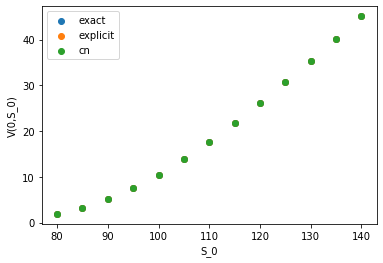

error american vs european: 0.00012768506247269354


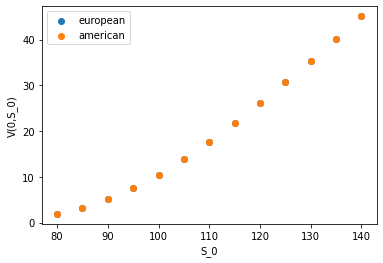

In [7]:
k=100
r=0.05
sigma=0.2
T=1

s_max=500

s_0=np.array([80,85,90,95,100,105,110,115,120,125,130,135,140])


true_solution=bs_pricing(s_0,T,sigma,r,k)

dt=0.0001
ds=1
index=get_index(s_0,s_max,ds)

time_aux=time.time()
explicit_solution=european_call_bs_explicit(k,r,sigma,T,dt,ds,s_max)[index]
print("time explicit:", time.time()-time_aux)
print("error explicit:", np.sqrt(np.linalg.norm(explicit_solution-true_solution)/len(s_0)))

dt=0.01
ds=0.5
index=get_index(s_0,s_max,ds)

time_aux=time.time()
cn_solution=european_call_bs_cn(k,r,sigma,T,dt,ds,s_max)[index]
print("time cn:", time.time()-time_aux)
print("error cn:", np.sqrt(np.linalg.norm(cn_solution-true_solution)/len(s_0)))

plt.scatter(s_0,true_solution)
plt.scatter(s_0,explicit_solution)
plt.scatter(s_0,cn_solution)
plt.legend(["exact","explicit","cn"])
plt.xlabel("S_0")
plt.ylabel("V(0,S_0)")
plt.show()

american_solution=american_call_bs_cn(k,r,sigma,T,dt,ds,s_max)[index]
      

plt.scatter(s_0,cn_solution)
plt.scatter(s_0,american_solution)
print("error american vs european:", np.sqrt(np.linalg.norm(cn_solution-american_solution)/len(s_0)))

plt.legend(["european","american"])
plt.xlabel("S_0")
plt.ylabel("V(0,S_0)")
plt.show()